In [5]:
import datetime, warnings, scipy
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec


In [6]:
from scipy.optimize import curve_fit
plt.rcParams["patch.force_edgecolor"]=True
plt.style.use('fivethirtyeight')
mpl.rc('patch',edgecolor='dimgray',linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns =50
%matplotlib inline
warnings.filterwarnings("ignore")

In [7]:
df=pd.read_csv('H:/flight delay/flights_short.csv',low_memory=False,nrows=5000)
print("DATAFRAME DIMENSION=",df.shape)

DATAFRAME DIMENSION= (5000, 31)


In [8]:
from os import mkdir, walk
from pdfminer.high_level import extract_text
from sentence_transformers import SentenceTransformer, util
from FileDetails import FileDetails

import bs4 as bs
import heapq
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import WordPunctTokenizer

import re
import pickle
import json


"""
*****************
  UTIL FUNCTIONS
*****************
"""
def get_file_list_from_folder(folder_name):
    file_list = []
    try:
        for(files) in walk(str(folder_name),topdown=True):
            file_list = files[len(files) - 1]
            # Code for cleaning up the file list remove all files starting with ._
            for i in file_list:
                if i.startswith("._"):
                    file_list.remove(i)
        return file_list
    except:
        raise FileNotFoundError


"""
***************************
  CONVERT PDF TO TXT CODE
***************************
"""
def remove_pdf_extension(string):
    string = str(string)
    string = string.split('.')
    return string[0]

def extract_text1(pdf_name):
    text = extract_text(pdf_name)
    return text

def save_in_txt_files(pdf_path):
    """
    Points to be noted while passing the pdf_name...
        1. The pdf_name is the pdf path like => Repository/pdf_name.pdf
    """
    print(pdf_path)
    path_splits = pdf_path.split("/")
    filepath = str("output/"+remove_pdf_extension(path_splits[len(path_splits)-1])+".txt")
    try:
        file = open(r"{}".format(filepath),"w")
        text = extract_text1(pdf_path)
        text = str(text)
        file.write(text)
        file.close()
        return text
    except:
        mkdir('output')


"""
*************************
    EXTRACT HEADINGS
*************************
"""
def extract_headings(text):
    """
        This function will find any headings in the text file. The regular expression finds the
    string with a number at the start following a period, following a space, following a alphanumberic characters

    Args: String - text
    Return: List(String)
    """
    line_list = []
    heading_list = []
    line_list = str(text).split("\n")
    for i in line_list:
        matchOject = re.compile(r'^[0-9]\.+\s+\w+[\s\w]+')
        temp_heading = matchOject.findall(i)
        if temp_heading != []:
            for i in temp_heading:
                heading_list.append(i)
    return heading_list

def extract_heading_in_list(path_to_txt_file):
    with open(path_to_txt_file,"r") as f:
        content = f.read()
        headings = extract_headings(content)
        f.close()
        return headings

def get_headings_from_list(txt_file_list,txt_folder_name):
    heading_frequency_dict = {}
    replaceObject = re.compile(r'^[0-9]\.+\s+')
    for i in txt_file_list:
        heading_list = extract_heading_in_list("{0}/{1}".format(txt_folder_name,i))
        for j in heading_list:
            processed_txt = replaceObject.split(j)
            processed_heading = processed_txt[len(processed_txt) - 1].upper().strip()
            if processed_heading in heading_frequency_dict:
                heading_frequency_dict[processed_heading] += 1
            else:
                heading_frequency_dict[processed_heading] = 1
    print(heading_frequency_dict,end='\n')


"""
********************************************
  EXTRACT REFERENCES AND SAVE IT IN FOLDER
********************************************
"""

def extract_reference_from_txt_file(path_of_txt_file,source_folder_name):
    txt_path = str(source_folder_name+"/"+path_of_txt_file)
    txt_file = open(txt_path,'r')
    ref_int = 0
    references = str("references/"+path_of_txt_file)
    try:
        ref_file = open(r"{}".format(references),"w")
        for i in txt_file:
            if ref_int == 1:
                ref_file.write(i)
            i = i.rstrip()

            if re.search(".*References|.*REFERENCES",i):
                ref_int=1
    except:
        try:
            mkdir('references')
        except:
            print("directory found!")
    txt_file.close()


"""
********************************************
  MATCHING REFERENCES WITH TITLE OF PAPERS
********************************************
"""
# Problem Solution: https://www.sbert.net/docs/usage/semantic_textual_similarity.html
# Sentence Transformet: https://pypi.org/project/sentence-transformers/

heading_find_regex = re.compile(r': [A-Za-z]+ .*')
number_check_regex_type_1 = re.compile(r'[0-9]+\.') # 21.
number_check_regex_type_2 = re.compile(r'\[[0-9]+\]') # [2]

def remove_starting_numbers(input_list):
    temp_list = []
    res_list = []
    temp_list = input_list
    for i in temp_list:
        sentence = i.split(' ')
        if number_check_regex_type_1.search(str(sentence[0])):
            sentence.remove(sentence[0])
            sen = " ".join(sentence)
            res_list.append(sen)
        elif number_check_regex_type_2.search(str(sentence[0])):
            sentence.remove(sentence[0])
            sen = " ".join(sentence)
            res_list.append(sen)
        else:
            res_list.append(sentence)
    
    for i in res_list:
        if i == ['']:
            res_list.remove(i)
    
    return res_list

def search_references(references_list,heading_list,model):
    ref_temp = references_list
    res_list = remove_starting_numbers(ref_temp)
    # search_dict = dict()
    for i in range(len(res_list)):
        encode_i = model.encode(res_list[i],convert_to_tensor=True)
        for j in heading_list:
            cosine_scores = util.cos_sim(encode_i,j['Encoding_data'])
            if cosine_scores[0][0] >= 0.7:
                print("S1:{0} \nS2:{1} \n\tScore: {2}".format(res_list[i],j['Title'],cosine_scores[0][0]))

def extract_references_from_file(file_path):
    sentence_list = []
    main_list = []
    ref_list = []
    match_only_list = []
    temp = ''
    txt_file = open(file_path,'r')
    temp = ''.join(txt_file)
    sentence_list = temp.splitlines(True)

    # Removing extra new-line characters.
    for i in sentence_list:
        if i == '\n':
            sentence_list.remove(i)

    for i in sentence_list:
        search_str = i.split(' ')[0]
        if number_check_regex_type_1.search(str(search_str)):
            # print(i)
            main_list.append((i,'MATCHED'))
            match_only_list.append(i)
            
        elif number_check_regex_type_2.search(str(search_str)):
            main_list.append((i,'MATCHED'))
        else:
            main_list.append((i,'NOT_MATCHED'))
    
    ref = ''
    for i in main_list:
        if i[1] == 'MATCHED':
            ref_list.append(ref)
            ref = i[0]
        else:
            ref += i[0]
    ref_list.append(ref)       
    
    ref_temp = []
    for i in ref_list:
        ref_temp.append(i.replace("\n", "").replace("\x0c",""))
    
    ref_list = ref_temp
    return ref_list
    

def get_title_names(model):
    json_file = open('REFERENCES.json')
    data_array = json.load(json_file)
    file_details_array = []
    for i in data_array:
        title_encode = model.encode(i['Title'],convert_to_tensor=True)
        # print(title_encode)
        file_details = FileDetails(i['Title'],i['Filename'],title_encode)
        file_details_array.append(file_details)
    return file_details_array

# This function should run only once or whenever necessary
def save_headings_to_pickle(model):
    file_details_array = get_title_names(model)
    processed_title = open('PROCESSED_REFERENCES.pkl','wb')
    processed_list = []
    for i in file_details_array:
        processed_list.append({"Title": i.title,"Path": i.path, "Encoding_data": i.encoding_data})
    pickle.dump(processed_list,processed_title)
    processed_title.close()


"""
*********************
  SUMMARY OF PAPERS
*********************
"""

def Summary(line_list):
    heading_list = []
    def TextSummarization(res):
        article = res

        parsed_article = bs.BeautifulSoup(article,'lxml')

        paragraphs = parsed_article.find_all('p')

        article_text = ""

        for p in paragraphs:
            article_text += p.text
        # Removing Square Brackets and Extra Spaces
        article_text = re.sub(r'\[[0-9]*\]', ' ', article_text)
        article_text = re.sub(r'\s+', ' ', article_text)
        # Removing special characters and digits
        formatted_article_text = re.sub('[^a-zA-Z]', ' ', article_text )
        formatted_article_text = re.sub(r'\s+',' ', formatted_article_text)
        sentence_list = nltk.sent_tokenize(article_text)
        stopwords = nltk.corpus.stopwords.words('english')
        
        word_frequencies = {}
        sentence_scores = {}
        for word in nltk.word_tokenize(formatted_article_text):
            if word not in stopwords:
                if word not in word_frequencies.keys():
                    word_frequencies[word] = 1
                else:
                    word_frequencies[word] += 1
            maximum_frequncy = max(word_frequencies.values())
            
        
        for word in word_frequencies.keys():
            word_frequencies[word] = (word_frequencies[word]/maximum_frequncy)
        for sent in sentence_list:
            for word in nltk.word_tokenize(sent.lower()):
                if word in word_frequencies.keys():
                    if len(sent.split(' ')) < 30:
                        if sent not in sentence_scores.keys():
                            sentence_scores[sent] = word_frequencies[word]
                        else:
                            sentence_scores[sent] += word_frequencies[word]
        summary_sentences = heapq.nlargest(7, sentence_scores, key=sentence_scores.get)

        summary = ' '.join(summary_sentences)
        output_file.write(summary)
        print(summary)
        
    def textExtraction(new_heading,heading_lower):
        c = [x for x in heading_lower if any(k in x for k in new_heading)]
        inverse_index = { element: index for index, element in enumerate(c) }

        #To find the index of the matched elements in the original heading list
        z= [(index) for index, element in enumerate(heading_lower) if element in inverse_index]
        #To extract the text under the sections
        res = ''
        for i in z:
            p=heading_list[i]
            if(p[3:]=="CONCLUSION" or p[3:]=="conclusion" or p[3:]=="Conclusion"):
                j=heading_list[i]
                k="REFERENCES"
            
    # getting index of substrings
                idx1 = line_list.index(j)
                idx2 = line_list.index(k)
                res = ''
    # getting elements in between
                for idx in range(idx1 + 1, idx2):
                    res = res + line_list[idx]
            else:
                j=heading_list[i]
                k=heading_list[i+1]
            # getting index of substrings
                idx1 = line_list.index(j)
                idx2 = line_list.index(k)
                res = ''
            # getting elements in between
                for idx in range(idx1 + 1, idx2):
                    res = res + line_list[idx]
                    print("res",res)
        section_extraction.write(res)
        TextSummarization(res)
    def synonymmatch(crct_heading,heading_list):
        a = (map(lambda x: x.lower(), heading_list))
        heading_lower= list(a)
        synonyms=["abstract","introduction","literature-survey","related work","background","methodology","analysis","comparison","discussion","results","conclusion","references"]
        new_heading=[]
        synonyms.append("CONCLUSIONS")
    #to check and extract the matching headings and synonyms
        for i in synonyms:
            if i in crct_heading:
                new_heading.append(i)
        new_heading=list(set([x for x in crct_heading if any(b in x for b in synonyms)]))
        textExtraction(new_heading,heading_lower)

    def ExtractHeading():
    
    # TO extract the headings
        for i in line_list:
            matchOject = re.compile(r'^[0-9]\.+\s+\w+[\s\w]+')
            temp_heading = matchOject.findall(i)
            if temp_heading != []:
                for i in temp_heading:
                    heading_list.append(i)
        
        crct_heading=[]

    #To find the headings without the section number to match with the synonyms and convert it to lower case
        for i in heading_list:
            matchOject = re.compile(r'\w+[\s\w]+')
            temp_heading = matchOject.findall(i)
            if temp_heading != []:
                for i in temp_heading:
                    crct_heading.append(i)
        for i in range(len(crct_heading)):
            crct_heading[i] = crct_heading[i].lower()
        synonymmatch(crct_heading,heading_list)
    ExtractHeading()


"""
****************
  MAIN FUNCTION
****************
"""
if __name__ == '__main__':
    option = int(input(
        """
        What operation do you want to perform select the appropriate option
            1. To setup the repository, convert the pdf data files to text
            2. To extract headings and display its frequency
            3. To extract references
            4. To find references with title names
            5. To find the summary of the input paper

        Enter the number for performing the given operation:
        """
    ))
    if option == 1:
        folder_name = str(input("Enter the folder name which has the pdf files: "))
        file_list = get_file_list_from_folder(folder_name)
        for pdf_path in file_list:
            save_in_txt_files("{0}/{1}".format(folder_name,pdf_path))

    elif option == 2:
        # NOTE 1: GET YOUR PDF AND TXT FILES SETUP BEFORE RUNNING THIS OPTION
        # NOTE 2: THIS IS A GENERATED FOLDER IT WILL BE GENERATED SO NEED OF CHANGING THE FOLDER NAME
        folder_name = 'output'
        file_list = get_file_list_from_folder(folder_name)
        get_headings_from_list(file_list,folder_name)

    elif option == 3:
        folder_name = 'output'
        file_list = get_file_list_from_folder(folder_name)
        for i in file_list:
            extract_reference_from_txt_file(i,folder_name)

    elif option == 4:
        print("Please wait... searching in our database!")
        model = SentenceTransformer('all-MiniLM-L6-v2')
        a_file = open('PROCESSED_REFERENCES.pkl','rb')
        output = pickle.load(a_file)
        a_file.close()
        reference_list = extract_references_from_file('references/2018Siva_OmnidirectionalMultisensoryPerceptionFusionLongTermPlaceRecognition.txt')
        search_references(reference_list,output,model)
    
    elif option==5:
        user_input=open('RS_2005.txt',encoding="utf-8")
        output_file=open('output.txt','w+')
        section_extraction=open('output1.txt','w+')
        text=user_input.read()
        line_list = []
        line_list = str(text).split("\n")
        Summary(line_list)
        output_file.close()
        user_input.close()
  

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
column type,int64,int64,int64,int64,object,int64,object,object,object,int64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,object,float64,float64,float64,float64,float64
null values(nb),0,0,0,0,0,0,6,0,0,0,285,285,286,286,0,297,297,0,288,288,0,288,297,0,0,4713,4342,4342,4342,4342,4342
null values(%),0,0,0,0,0,0,0.12,0,0,0,5.7,5.7,5.72,5.72,0,5.94,5.94,0,5.76,5.76,0,5.76,5.94,0,0,94.26,86.84,86.84,86.84,86.84,86.84


In [9]:
df['DATE']=pd.to_datetime(df[['YEAR','MONTH','DAY']])

In [10]:
import logging

In [11]:
def format_time(t):
    if pd.isnull(t):
        return np.nan
    else:
        if t == 2400: t = 0
        t = "{0:04d}".format(int(t))
        hour = datetime.time(int(t[0:2]), int(t[2:4]))
        return hour
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_time(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    lst = []
    for index, cols in df[['DATE', col]].iterrows(): 
        logging.debug(cols[1])
        if pd.isnull(cols[1]):
            lst.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            lst.append(combine_date_time(cols))
        else:
            cols[1] = format_time(cols[1])
            lst.append(combine_date_time(cols))
    return pd.Series(lst)

In [12]:
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_time)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_time)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_time)

df.loc[:5, ['DATE','SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]


,DATE,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,DEPARTURE_TIME,ARRIVAL_TIME,DEPARTURE_DELAY,ARRIVAL_DELAY
0,2015-01-01,2015-01-01 00:05:00,04:30:00,23:54:00,04:08:00,-11.0,-22.0
1,2015-01-01,2015-01-01 00:10:00,07:50:00,00:02:00,07:41:00,-8.0,-9.0
2,2015-01-01,2015-01-01 00:20:00,08:06:00,00:18:00,08:11:00,-2.0,5.0
3,2015-01-01,2015-01-01 00:20:00,08:05:00,00:15:00,07:56:00,-5.0,-9.0
4,2015-01-01,2015-01-01 00:25:00,03:20:00,00:24:00,02:59:00,-1.0,-21.0
5,2015-01-01,2015-01-01 00:25:00,06:02:00,00:20:00,06:10:00,-5.0,8.0


In [18]:
df=df[['AIRLINE','ORIGIN_AIRPORT','DESTINATION_AIRPORT','SCHEDULED_DEPARTURE','DEPARTURE_TIME','DEPARTURE_DELAY','SCHEDULED_ARRIVAL','ARRIVAL_TIME','ARRIVAL_DELAY','SCHEDULED_TIME','ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235,215.0


In [58]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns=['variable','missing values']
missing_df['filling factor(%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('filling factor(%)').reset_index(drop=True)

,variable,missing values,filling factor(%)
0,ARRIVAL_DELAY,297,94.06
1,ELAPSED_TIME,297,94.06
2,ARRIVAL_TIME,288,94.24
3,DEPARTURE_TIME,285,94.30
4,DEPARTURE_DELAY,285,94.30
5,AIRLINE,0,100.00
6,ORIGIN_AIRPORT,0,100.00
7,DESTINATION_AIRPORT,0,100.00
8,SCHEDULED_DEPARTURE,0,100.00
9,SCHEDULED_ARRIVAL,0,100.00


In [73]:
df.dropna(inplace=True)
df

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205,194.0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280,279.0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286,293.0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285,281.0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235,215.0
...,...,...,...,...,...,...,...,...,...,...,...
4995,DL,SEA,DTW,2015-01-01 11:47:00,11:42:00,-5.0,18:55:00,18:27:00,-28.0,248,225.0
4996,UA,DEN,BOI,2015-01-01 11:48:00,11:50:00,2.0,13:52:00,13:34:00,-18.0,124,104.0
4997,UA,IAH,SAN,2015-01-01 11:48:00,11:49:00,1.0,13:20:00,13:08:00,-12.0,212,199.0
4998,OO,RAP,DEN,2015-01-01 11:48:00,12:38:00,50.0,13:10:00,13:48:00,38.0,82,70.0


In [60]:
airlines_name=pd.read_csv('H:/flight delay/airlines.csv')
airlines_name
abbr_companies = airlines_name.set_index('IATA_CODE')['AIRLINE'].to_dict()
abbr_companies

{'UA': 'United Air Lines Inc.',
 'AA': 'American Airlines Inc.',
 'US': 'US Airways Inc.',
 'F9': 'Frontier Airlines Inc.',
 'B6': 'JetBlue Airways',
 'OO': 'Skywest Airlines Inc.',
 'AS': 'Alaska Airlines Inc.',
 'NK': 'Spirit Air Lines',
 'WN': 'Southwest Airlines Co.',
 'DL': 'Delta Air Lines Inc.',
 'EV': 'Atlantic Southeast Airlines',
 'HA': 'Hawaiian Airlines Inc.',
 'MQ': 'American Eagle Airlines Inc.',
 'VX': 'Virgin America'}

In [66]:
def get_stats(group):
    return {'min':group.min(),'max':group.max(),'count':group.count(),'mean':group.mean()}

gs=df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
gs

,min,max,count,mean
AIRLINE,,,,
AA,-15.0,339.0,476.0,8.699580
AS,-16.0,124.0,189.0,0.227513
B6,-18.0,175.0,301.0,2.116279
DL,-14.0,243.0,633.0,3.308057
EV,-22.0,364.0,404.0,2.695545
F9,-13.0,80.0,90.0,5.188889
HA,-13.0,171.0,83.0,5.072289
MQ,-14.0,236.0,168.0,6.392857
NK,-16.0,108.0,113.0,7.796460


In [72]:
global_stats=df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats=global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-9.0,59.0,50.0,1.000000
HA,-13.0,171.0,83.0,5.072289
F9,-13.0,80.0,90.0,5.188889
NK,-16.0,108.0,113.0,7.796460
MQ,-14.0,236.0,168.0,6.392857
AS,-16.0,124.0,189.0,0.227513
B6,-18.0,175.0,301.0,2.116279
US,-13.0,164.0,342.0,1.307018
EV,-22.0,364.0,404.0,2.695545


In [52]:
df2 = df.loc[:,['AIRLINE','DEPARTURE_DELAY']]
df2['AIRLINE']=df2['AIRLINE'].replace(abbr_companies)

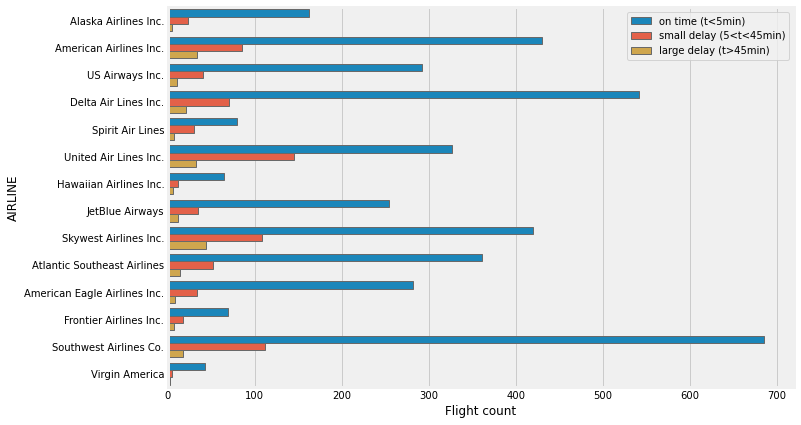

In [61]:
delay_type = lambda x:( (0,1)[x>5],2)[x>45]
df['DELAY_LEVEL']=df['DEPARTURE_DELAY'].apply(delay_type)
fig = plt.figure(1,figsize=(10,7))
ax=sns.countplot(y='AIRLINE',hue='DELAY_LEVEL', data=df)
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.xlabel('Flight count')
L=plt.legend()
L.get_texts()[0].set_text('on time (t<5min)')
L.get_texts()[1].set_text('small delay (5<t<45min)')
L.get_texts()[2].set_text('large delay (t>45min)')
plt.show()

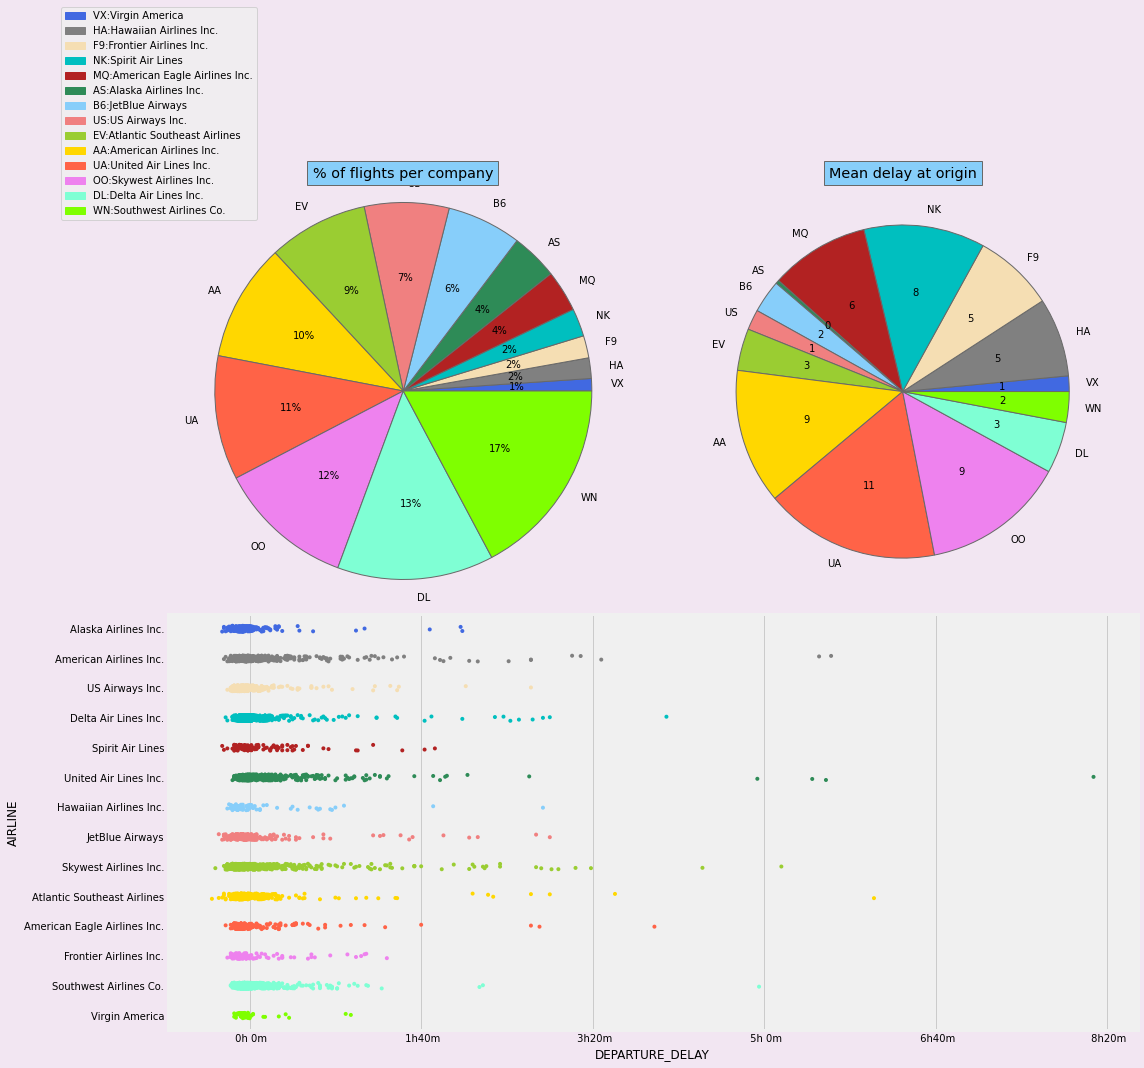

In [73]:
#CODE FOR PIE CHART
import matplotlib.patches as mpatches
df2 = df.loc[:,['AIRLINE','DEPARTURE_DELAY']]
df2['AIRLINE']=df2['AIRLINE'].replace(abbr_companies)

fig = plt.figure(1,figsize=(16,15))
gs = GridSpec(2,2)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
#pie chart 1
labels = [s for s in global_stats.index]
sizes=global_stats['count'].values
patches,texts, autotexts = ax1.pie(sizes, labels=labels,colors=colors,autopct='%1.0f%%',shadow=False, startangle=0)

ax1.axis('equal')
ax1.set_title('% of flights per company',bbox={'facecolor':'lightskyblue','pad':5})
comp_handler=[]
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],label=global_stats.index[i]+':'+
                                       abbr_companies[global_stats.index[i]]) )

ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2,0.9))

#mean delay of depature : Pie chart 2
sizes = global_stats['mean'].values
sizes = [max(s,0) for s in sizes]
patches,texts, autotexts = ax2.pie(sizes, labels=labels,colors=colors,
                                   autopct=lambda p:'{:.0f}'.format(p*sum(sizes)/100),shadow=False, startangle=0)

ax2.set_title('Mean delay at origin',bbox={'facecolor':'lightskyblue','pad':5})
# strip plot with all values of delays
ax3= sns.stripplot(y='AIRLINE',x='DEPARTURE_DELAY',size=4,palette=colors,data=df2)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y)for y in divmod(x,60)])
                    for x in ax3.get_xticks()])

fig.patch.set_facecolor((0.95,0.9,0.95))
plt.tight_layout(w_pad=3)


In [74]:
#pie chart 1
labels = [s for s in global_stats.index]
sizes=global_stats['count'].values
patches,texts, autotexts = ax1.pie(sizes, labels=labels,colors=colors,autopct='%1.0f%%',shadow=False, startangle=0)

ax1.axis('equal')
ax1.set_title('% of flights per company',bbox={'facecolor':'lightskyblue','pad':5})
comp_handler=[]
for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(color=colors[i],label=global_stats.index[i]+':'+
                                       abbr_companies[global_stats.index[i]]) )

ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2,0.9))
#mean delay of depature : Pie chart 2
sizes = global_stats['mean'].values
sizes = [max(s,0) for s in sizes]
patches,texts, autotexts = ax2.pie(sizes, labels=labels,colors=colors,
                                   autopct=lambda p:'{:.0f}'.format(p*sum(sizes)/100),shadow=False, startangle=0)

ax2.set_title('Mean delay at origin',bbox={'facecolor':'lightskyblue','pad':5})

Text(0.5, 1.0, 'Mean delay at origin')

In [78]:
ax1.axis('equal')
ax1.set_title('Number of flights')
comp_handler=[]

for i in range(len(abbr_companies)):
    comp_handler.append(mpatches.Patch(label=global_stats.index[i]+':'+ abbr_companies[global_stats.index[i]]) )

ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2,0.9))

fig.patch.set_facecolor((0.95,0.9,0.95))
plt.tight_layout()


<Figure size 432x288 with 0 Axes>

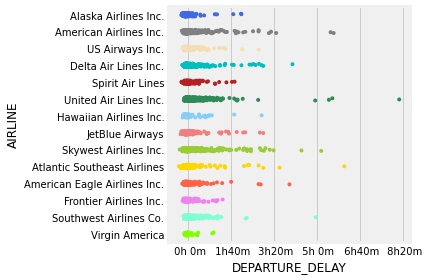

In [79]:
# strip plot with all values of delays
ax3= sns.stripplot(y='AIRLINE',x='DEPARTURE_DELAY',size=4,palette=colors,data=df2)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y)for y in divmod(x,60)])
                    for x in ax3.get_xticks()])

fig.patch.set_facecolor((0.95,0.9,0.95))
plt.tight_layout(w_pad=3)
#2 pie charts and strip plot

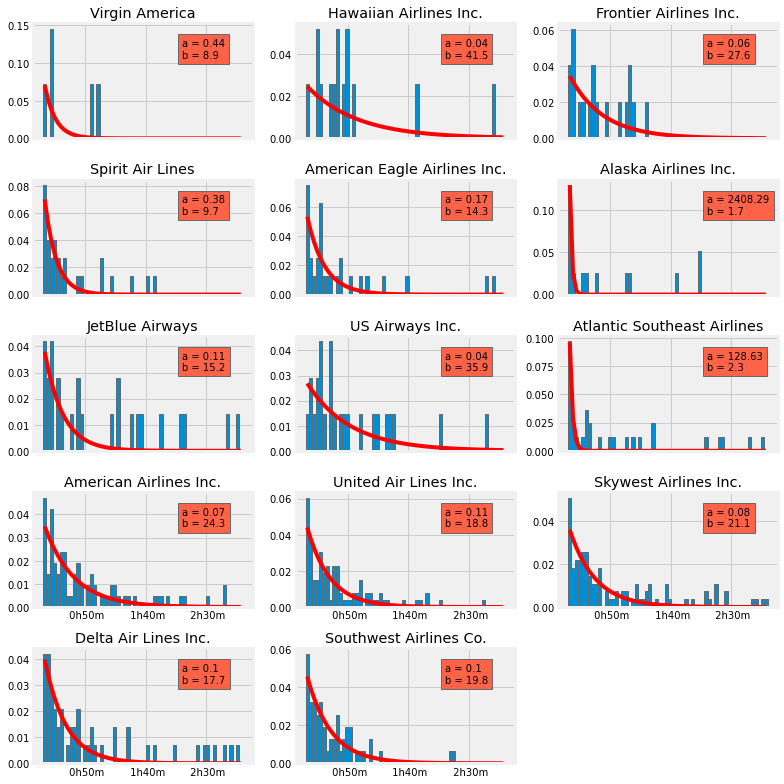

In [80]:
def func(x,a,b):
    return a*np.exp(-x/b)

points=[]; label_company=[]
fig=plt.figure(1,figsize=(11,11))
i=0
for carrier_name in [abbr_companies[x] for x in global_stats.index]:
    i+=1
    ax=fig.add_subplot(5,3,i)
    n,bins,patches= plt.hist(x=df2[df2['AIRLINE']==carrier_name]
                             ['DEPARTURE_DELAY'], density=1,
                             range=(15,180), bins=60)
    
    bin_centers=bins[:-1]+0.5*(bins[1:]-bins[:-1]) # for all 60 bins

    #print(bins[:-1]+0.5*(bins[1:] - bins[:-1]))
    
    popt,pcov = curve_fit(func,bin_centers,n,p0=[1,2])
    points.append(popt)
    label_company.append(carrier_name)
    

    plt.plot(bin_centers, func(bin_centers, *popt), 'r-')
    
    if i < 10:
        ax.set_xticklabels(['' for x in ax.get_xticks()])
    else:
        ax.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                            for x in ax.get_xticks()])

    ax.text(0.68, 0.7, 'a = {}\nb = {}'.format(round(popt[0],2), 
                        round(popt[1],1)),transform=ax.transAxes,bbox={'facecolor':'tomato'})
    plt.title(carrier_name)

plt.tight_layout()

In [81]:
carrier = 'WN'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,min,max,count,mean
ORIGIN_AIRPORT,,,,
PNS,-5.0,-5.0,1.0,-5.0
LBB,-9.0,-9.0,1.0,-9.0
AMA,-6.0,-6.0,1.0,-6.0
GSP,-2.0,-2.0,1.0,-2.0
DSM,-5.0,-5.0,1.0,-5.0


Text(0.5, 0, 'Mean delay[min] (@departure:blue @arrival: hatch lines)')

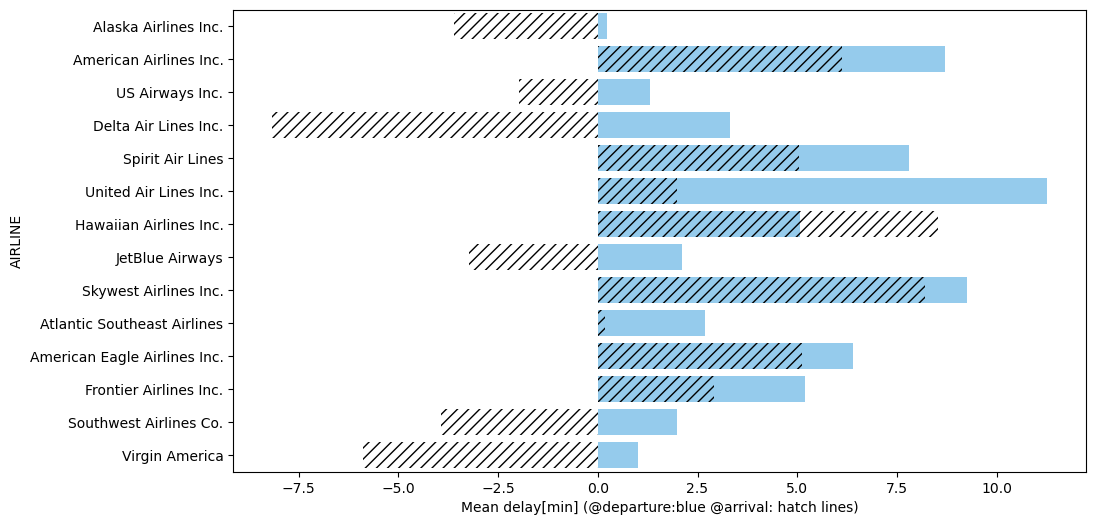

In [119]:
mpl.rcParams.update(mpl.rcParamsDefault)

fig=plt.figure(1,figsize=(11,6))
ax=sns.barplot(x='DEPARTURE_DELAY',y='AIRLINE', data=df,ci=None,
               color='lightskyblue')
ax=sns.barplot(x='ARRIVAL_DELAY',y='AIRLINE', alpha = 0.0,ci=None,
               data=df, hatch='///')

labels=[abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)

plt.xlabel('Mean delay[min] (@departure:blue @arrival: hatch lines)')

In [120]:
print('Number of airports:{}'.format(len(df['ORIGIN_AIRPORT'].unique())))

Number of airports:289


In [121]:
class Figure_style():
    #_________________________________________________________________
    def __init__(self, size_x = 11, size_y = 5, nrows = 1, ncols = 1):
        sns.set_style("white")
        sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 2.5})
        self.fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(size_x,size_y,))
        #________________________________
        # convert self.axs to 2D array
        if nrows == 1 and ncols == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif nrows == 1:
            self.axs = np.reshape(axs, (1, -1))
        elif ncols == 1:
            self.axs = np.reshape(axs, (-1, 1))
    #_____________________________
    def pos_update(self, ix, iy):
        self.ix, self.iy = ix, iy
    #_______________
    def style(self):
        self.axs[self.ix, self.iy].spines['right'].set_visible(False)
        self.axs[self.ix, self.iy].spines['top'].set_visible(False)
        self.axs[self.ix, self.iy].yaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].xaxis.grid(color='lightgray', linestyle=':')
        self.axs[self.ix, self.iy].tick_params(axis='both', which='major',
                                               labelsize=10, size = 5)
    #________________________________________
    def draw_legend(self, location='upper right'):
        legend = self.axs[self.ix, self.iy].legend(loc = location, shadow=True,
                                        facecolor = 'g', frameon = True)
        legend.get_frame().set_facecolor('whitesmoke')
    #_________________________________________________________________________________
    def cust_plot(self, x, y, color='b', linestyle='-', linewidth=1, marker=None, label=''):
        if marker:
            markerfacecolor, marker, markersize = marker[:]
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                linewidth = linewidth, marker = marker, label = label,
                                markerfacecolor = markerfacecolor, markersize = markersize)
        else:
            self.axs[self.ix, self.iy].plot(x, y, color = color, linestyle = linestyle,
                                        linewidth = linewidth, label=label)
        self.fig.autofmt_xdate()
    #________________________________________________________________________
    def cust_scatter(self, x, y, color = 'lightblue', markeredge = False, label=''):
        markeredgewidth = 1 if markeredge else 0
        self.axs[self.ix, self.iy].scatter(x, y, color=color,  edgecolor='grey',
                                  linewidths = markeredgewidth, label=label)    

    def set_xlabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_xlabel(label, fontsize = fontsize)

    def set_ylabel(self, label, fontsize = 14):
        self.axs[self.ix, self.iy].set_ylabel(label, fontsize = fontsize)
 

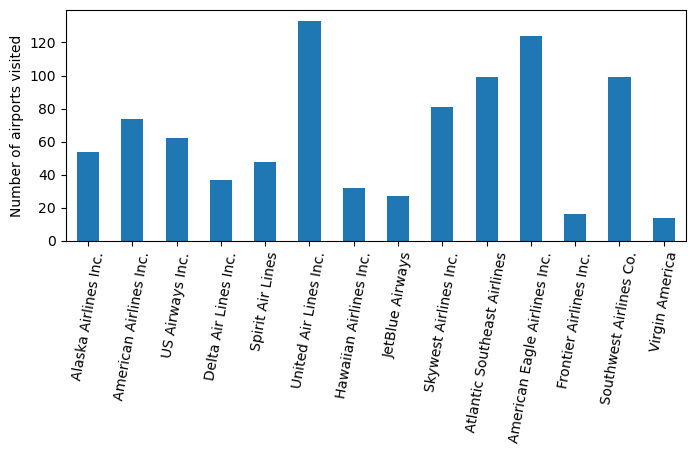

In [88]:
origin_nb=dict()
for carrier in abbr_companies.keys():
    list_origin_airport=df[df['AIRLINE']==carrier]['ORIGIN_AIRPORT'].unique()
    origin_nb[carrier]=len(list_origin_airport)
test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns={0:'count'},inplace=True)
ax = test_df.plot(kind='bar', figsize = (8,3))
plt.ylabel('Number of airports visited')
ax.set_xticklabels(labels)
plt.setp(ax.get_xticklabels(), rotation = 80)
ax.legend().set_visible(False)

In [117]:
temp = pd.read_csv('H:/flight delay/airports.csv')
identify_airport = temp.set_index('IATA_CODE')['CITY'].to_dict()
latitude_airport = temp.set_index('IATA_CODE')['LATITUDE'].to_dict()
longitude_airport = temp.set_index('IATA_CODE')['LONGITUDE'].to_dict()

In [116]:
df_train = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) < datetime.date(2015, 1, 23)]
df_test  = df[df['SCHEDULED_DEPARTURE'].apply(lambda x:x.date()) > datetime.date(2015, 1, 23)]
df = df_train
df_train

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME,DELAY_LEVEL
0,AS,ANC,SEA,2015-01-01 00:05:00,23:54:00,-11.0,04:30:00,04:08:00,-22.0,205,194.0,0
1,AA,LAX,PBI,2015-01-01 00:10:00,00:02:00,-8.0,07:50:00,07:41:00,-9.0,280,279.0,0
2,US,SFO,CLT,2015-01-01 00:20:00,00:18:00,-2.0,08:06:00,08:11:00,5.0,286,293.0,0
3,AA,LAX,MIA,2015-01-01 00:20:00,00:15:00,-5.0,08:05:00,07:56:00,-9.0,285,281.0,0
4,AS,SEA,ANC,2015-01-01 00:25:00,00:24:00,-1.0,03:20:00,02:59:00,-21.0,235,215.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,DL,SEA,DTW,2015-01-01 11:47:00,11:42:00,-5.0,18:55:00,18:27:00,-28.0,248,225.0,0
4996,UA,DEN,BOI,2015-01-01 11:48:00,11:50:00,2.0,13:52:00,13:34:00,-18.0,124,104.0,0
4997,UA,IAH,SAN,2015-01-01 11:48:00,11:49:00,1.0,13:20:00,13:08:00,-12.0,212,199.0,0
4998,OO,RAP,DEN,2015-01-01 11:48:00,12:38:00,50.0,13:10:00,13:48:00,38.0,82,70.0,2


In [113]:
carrier = 'WN'
check_airports = df[(df['AIRLINE'] == carrier)]['DEPARTURE_DELAY'].groupby(
                         df['ORIGIN_AIRPORT']).apply(get_stats).unstack()
check_airports.sort_values('count', ascending = False, inplace = True)
check_airports[-5:]

,min,max,count,mean
ORIGIN_AIRPORT,,,,
PNS,-5.0,-5.0,1.0,-5.0
LBB,-9.0,-9.0,1.0,-9.0
AMA,-6.0,-6.0,1.0,-6.0
GSP,-2.0,-2.0,1.0,-2.0
DSM,-5.0,-5.0,1.0,-5.0
